In [1]:
import pathlib
import scipy.constants
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fytok.Tokamak import Tokamak
from fytok.modules.CoreProfiles import CoreProfiles
from fytok.modules.Equilibrium import Equilibrium
from spdm.view import View as sp_view
from spdm.data.Path import Path
from spdm.data.Function import Function

data_path = pathlib.Path("/home/salmon/workspace/fytok_data/data/15MA inductive - burn")

astra_profiles = pd.read_excel(
    next(data_path.glob("*ASTRA.xls")).absolute().as_posix(), sheet_name=1, header=10, usecols="B:BN"
)

2024-01-15 13:25:56,843 [    spdm]     INFO: 
###################################################################################################

    ______      _____     _
   / ____/_  __|_   _|__ | | __
  / /_  / / / /  | |/ _ \| |/ /
 / __/ / /_/ /   | | (_) |   <
/_/    \__, /    |_|\___/|_|\_\
      /____/

 Copyright (c) 2021-present Zhi YU (Institute of Plasma Physics Chinese Academy of Sciences)
            
 url: https://gitee.com/openfusion/fytok_tutorial 
      https://github.com/fusion-yun/fytok_tutorial

 version = alpha  (spdm=beta extension=0.2.2.dev19+g14adade.d20231205, imas_version=v3_38_1_dirty)

 Run by salmon at 2024-01-15T13:25:56.735067.
 Job ID: fytok_salmon_surface_13648

###################################################################################################



In [2]:
core_profiles_astra = CoreProfiles(
    f"file+iterprofiles://{next(data_path.glob('*ASTRA.xls')).absolute().as_posix()}#core_profiles"
)

core_profiles_1d_astra = core_profiles_astra.time_slice.current.profiles_1d

equilibrium_astra = Equilibrium(f"file+geqdsk://{next(data_path.glob('**/g*.txt')).absolute().as_posix()}#equilibrium")


2024-01-15 13:25:57,093 [    spdm]     INFO: Load module spdm.plugins.data.plugin_iterprofiles
2024-01-15 13:25:57,151 [    spdm]     INFO: Initialize module fytok.modules.CoreProfiles 
2024-01-15 13:25:57,193 [    spdm]     INFO: Load module fytok.plugins.equilibrium.fy_eq
2024-01-15 13:25:57,194 [    spdm]     INFO: Load module spdm.plugins.data.plugin_geqdsk
2024-01-15 13:25:57,212 [    spdm]     INFO: Initialize module fytok.plugins.equilibrium.FyEqAnalyze 


In [3]:
tokamak = Tokamak(
    f"file+iterprofiles://{next(data_path.glob('*ASTRA.xls')).absolute().as_posix()}",
    f"file+geqdsk://{next(data_path.glob('**/g*.txt')).absolute().as_posix()}",
    device="iter",
    shot=900003,
    equilibrium={"code": {"parameters": {"psi_norm": np.linspace(0.0001, 0.999, 128)}}},
    core_transport={
        "model": [
            {"code": {"name": "dummy"}},
            # {"code": {"name": "fast_alpha"}},
        ]
    },
    core_sources={
        "source": [
            {"code": {"name": "dummy"}},
            {"code": {"name": "collisional_equipartition"}},
            # {"code": {"name": "fusion", "parameters": {"fusion_reactions": ["D(t,n)alpha"]}}},
            # {"code": {"name": "radiation"}},
            # {"code": {"name": "synchrotron_radiation"}},
        ]
    },
    transport_solver={
        "code": {
            "name": "fy_trans",
            "parameters": {
                "rho_tor_norm": np.linspace(0.01, 0.995, 128),
                # "bvp_rms_mask": [0.96],
                "hyper_diff": 1.0e-5,
                "max_nodes": 512,
                "bc_tol": 1,
                "verbose": 2,
                "units": {
                    "*/density": 1.0e21,
                    "*/density_flux": 1.0e24,
                    "ion/alpha/density": 1.0e18,
                    "ion/alpha/density_flux": 1.0e21,
                    "*/temperature": 1.0e6,
                    "*/temperature_flux": 1.0e27,
                },
            },
        },
        "ion_thermal": ["D", "T"],  #
        # "ion_non_thermal": ["alpha", "He"],
        # "impurities": ["Ar", "Be"],
        "boundary_condition_type": {
            # fmt: off
            # psi                          at axis \frac{d\psi}{dx}=0  , at boundary \psi=?
            "psi"                       : 1, 
            # density                      at axis \Gamma_s=0          , at boundary n=?
            "*/density"                 : 1, 
            # temperatur                   at axis \frac{dT}{dx}=0     , at boundary T=?
            "*/temperature"             : 1,
            # fmt: on
        },
    },
)

2024-01-15 13:25:57,299 [    spdm]     INFO: Load module spdm.plugins.data.plugin_xml


In [4]:
tokamak.initialize()

2024-01-15 13:25:57,316 [    spdm]     INFO: Initialize module fytok.modules.CoreProfiles 
2024-01-15 13:25:57,324 [    spdm]     INFO: Initialize module fytok.plugins.equilibrium.FyEqAnalyze 
2024-01-15 13:25:57,332 [    spdm]     INFO: Initialize module fytok.modules.Wall 
2024-01-15 13:25:57,335 [    spdm]     INFO: Initialize module fytok.modules.TF 
2024-01-15 13:25:57,338 [    spdm]     INFO: Initialize module fytok.modules.Magnetics 
2024-01-15 13:25:57,342 [    spdm]     INFO: Initialize module fytok.modules.PFActive 
2024-01-15 13:25:57,347 [    spdm]     INFO: Initialize module fytok.modules.CoreSources 
2024-01-15 13:25:57,354 [    spdm]     INFO: Initialize module fytok.plugins.core_sources.source.dummy 
2024-01-15 13:25:57,361 [    spdm]     INFO: Load module fytok.plugins.core_sources.source.collisional_equipartition
2024-01-15 13:25:57,364 [    spdm]     INFO: Initialize module fytok.plugins.core_sources.source.collisional_equipartition 
2024-01-15 13:25:57,372 [    spdm

In [5]:
solver = tokamak.transport_solver

In [6]:
solver_1d = solver.preprocess(
    time=0.0,
    # fmt:off
    initial_value={
        "psi":0.0,
        "ion/D/density":                    1.0e19,
        "ion/T/density":                    1.0e19,
        "ion/He/density":                   1.0,
        "ion/alpha/density":                1.0,

        "ion/D/temperature":                2.0e3,
        "ion/T/temperature":                2.0e3,
        "ion/He/temperature":               2.0e3,
        "electrons/temperature":            2.0e3,
    },
    boundary_value={
        "ion/D/density":                    1.3e19, 
        "ion/T/density":                    1.3e19, 
        "ion/He/density":                   1.0, 
        "ion/alpha/density":                1.0, 

        "ion/D/temperature":                200,   
        "ion/T/temperature":                200,   
        "ion/He/temperature":               200,   
        "electrons/temperature":            200,   
    },
    # fmt:on
)

2024-01-15 13:25:57,472 [    spdm]    DEBUG: /home/salmon/workspace/fytok/python/fytok/plugins/equilibrium/fy_eq/fy_eq.py:94:__init__: Create FyEquilibriumCoordinateSystem <FyEquilibriumCoordinateSystem name='coordinate_system' />
2024-01-15 13:25:57,478 [    spdm]     INFO: Load module spdm.mesh.mesh_rectangular
2024-01-15 13:25:57,513 [    spdm]  WARNING: /home/salmon/workspace/fytok/python/fytok/plugins/equilibrium/fy_eq/fy_eq.py:132:__init__: Singular values are caused when psi_norm takes values of 0.0 or 1.0.! 0.0 1.0


2024-01-15 13:25:58,580 [    spdm]     INFO: Load module spdm.view.view_matplotlib


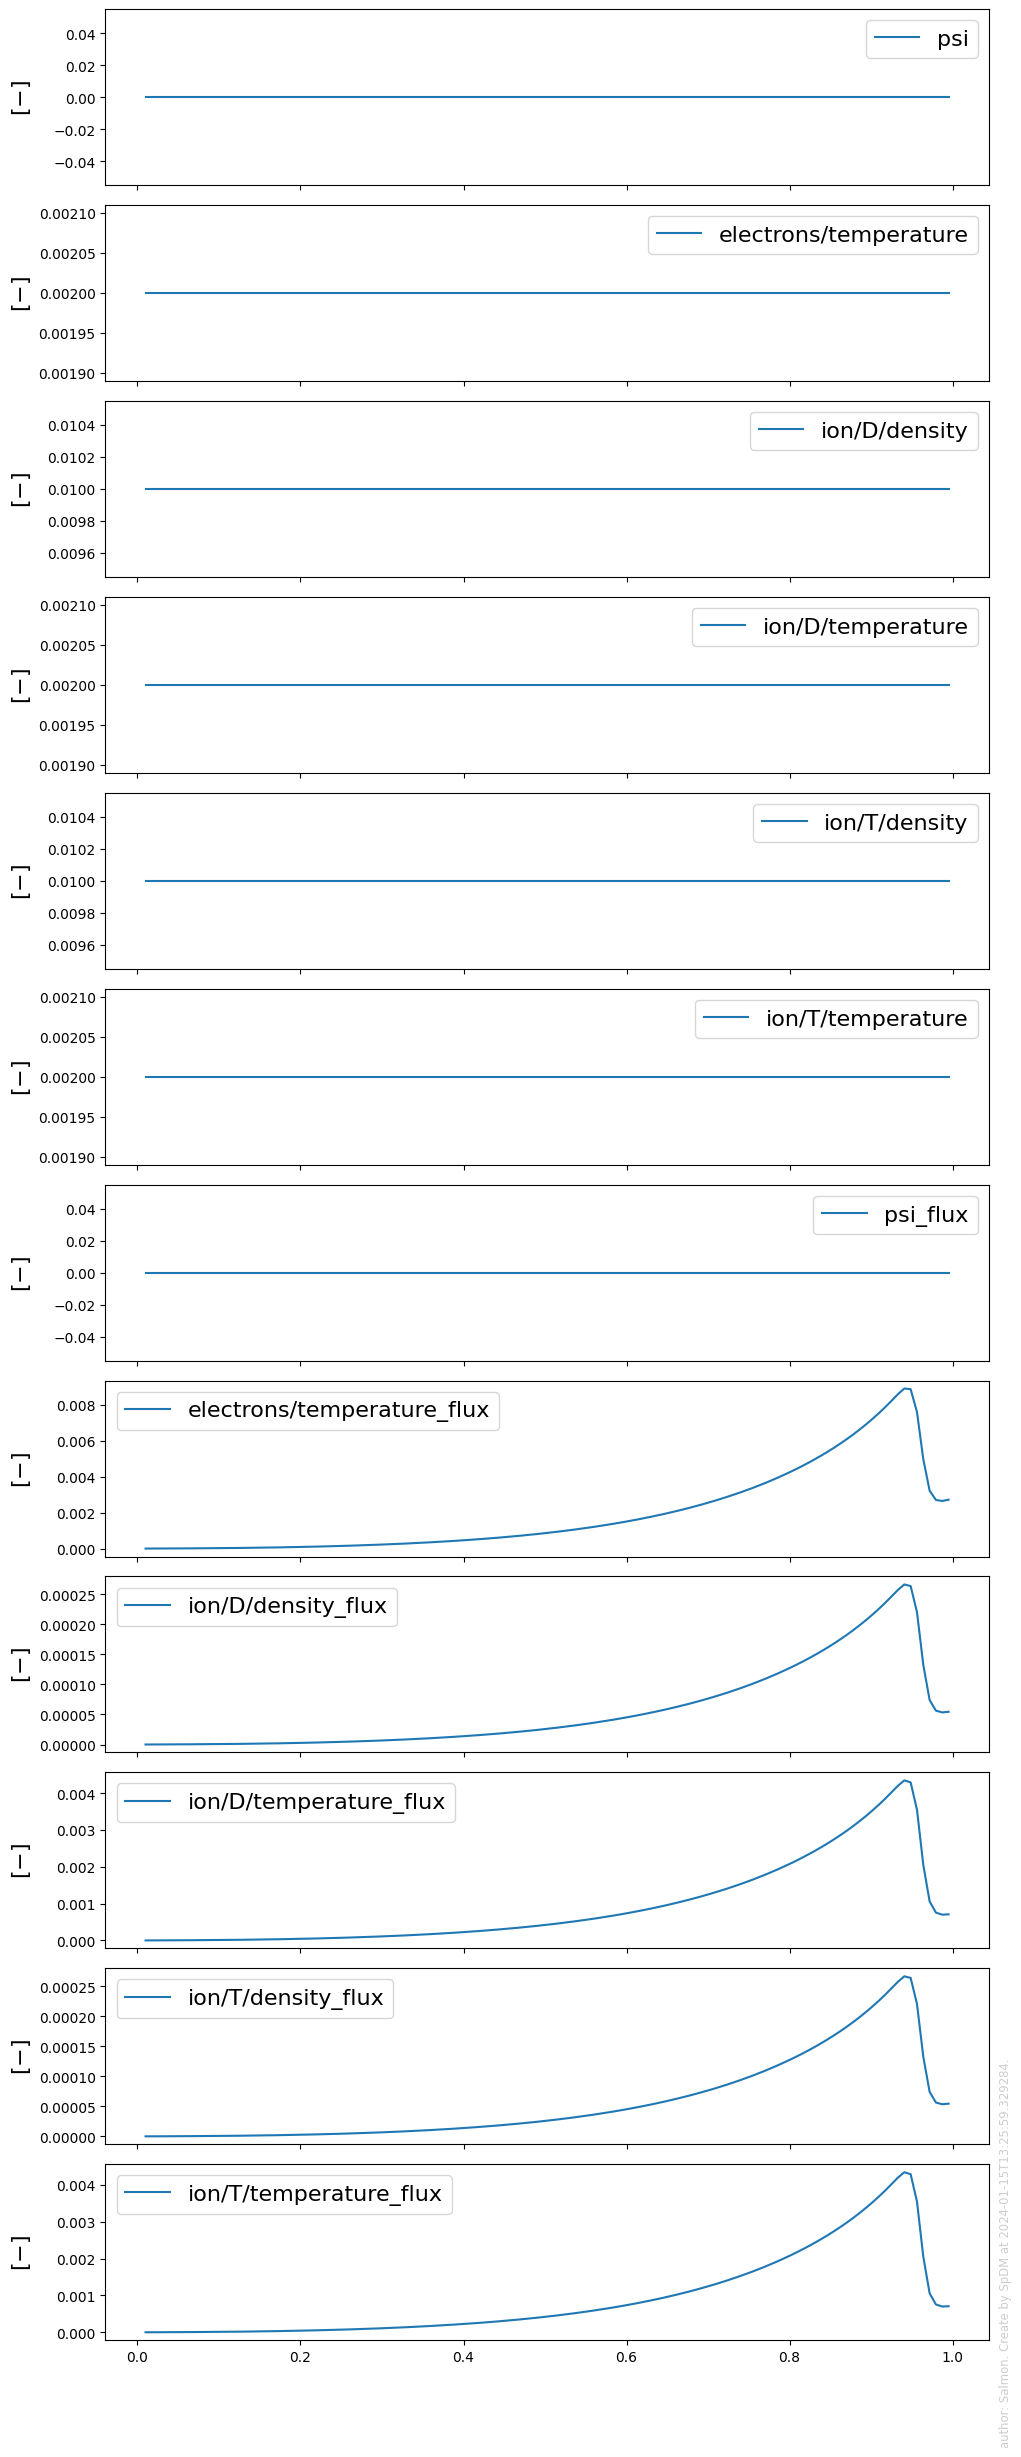

In [7]:
fig = sp_view.plot(
    solver_1d.X,
    *[(solver_1d.Y[idx * 2], equ.identifier) for idx, equ in enumerate(solver.equations)],
    *[(solver_1d.Y[idx * 2+1], f"{equ.identifier}_flux") for idx, equ in enumerate(solver.equations)],
)

In [8]:
solver_1d = solver.execute(solver_1d)
solver_1d = solver.postprocess(solver_1d)

2024-01-15 13:26:01,773 [    spdm]     INFO: Solve transport equations : psi  ,electrons/temperature  ,ion/D/density  ,ion/D/temperature  ,ion/T/density  ,ion/T/temperature
2024-01-15 13:26:01,775 [    spdm]     INFO: Execute module fytok.plugins.transport_solver_numerics.fy_trans FyTrans
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          5.03e-03       7.10e-23          128            15       
       2          1.36e-03       3.36e-20          143             1       
       3          9.09e-04       7.69e-25          144             0       
Solved in 3 iterations, number of nodes 144. 
Maximum relative residual: 9.09e-04 
Maximum boundary residual: 7.69e-25
2024-01-15 13:26:03,779 [    spdm]    DEBUG: /home/salmon/workspace/fytok/python/fytok/plugins/transport_solver_numerics/fy_trans/fy_trans.py:752:execute: Solve BVP success: The algorithm converged to the desired accuracy. , 3 iterations
2024-01-15 13:26:03,780 [    spdm]     INFO: Solv

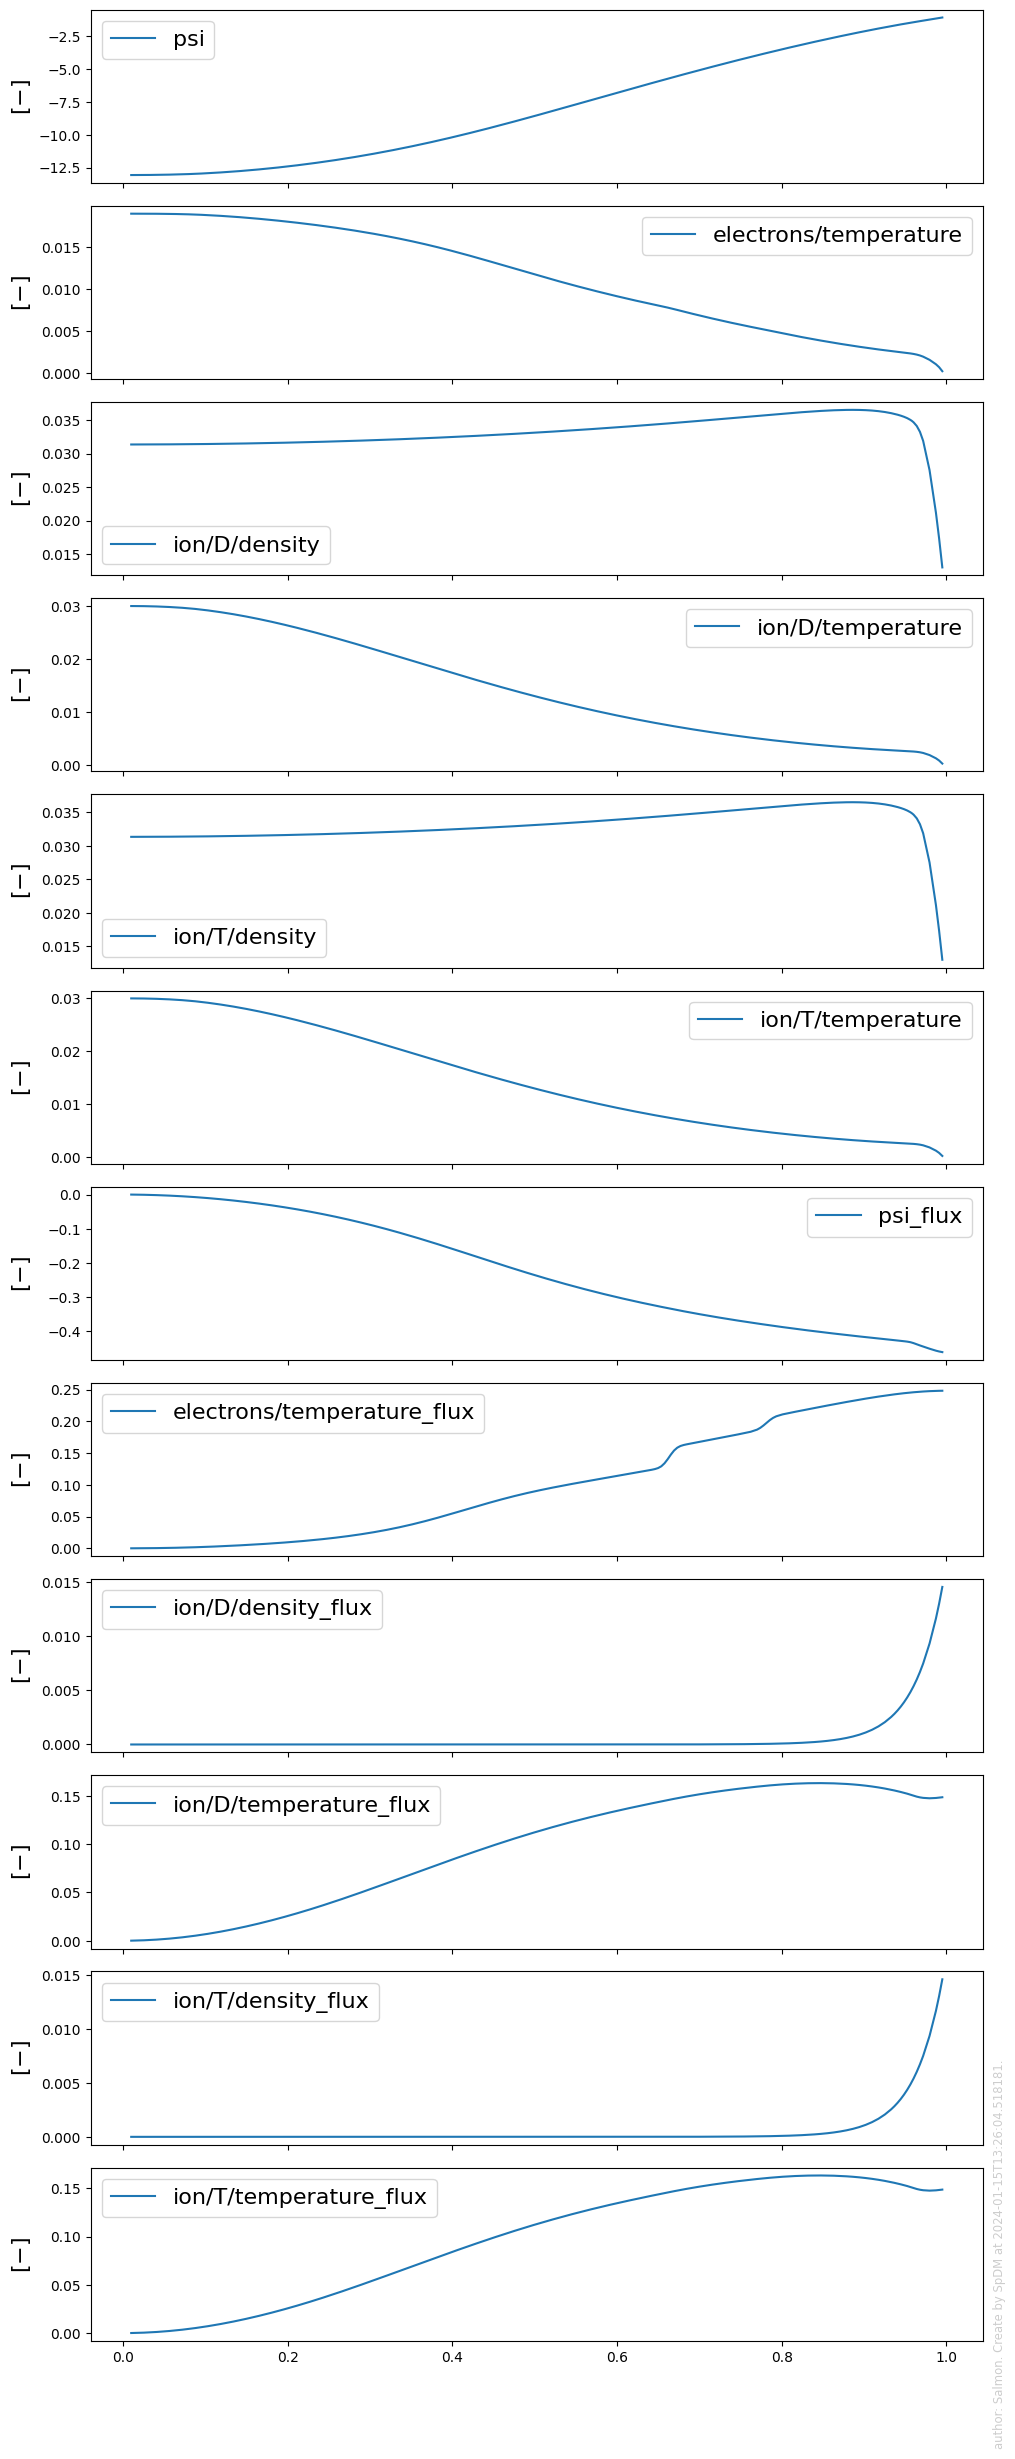

In [9]:
fig = sp_view.plot(
    solver_1d.X,
    *[(solver_1d.Y[idx * 2], equ.identifier) for idx, equ in enumerate(solver.equations)],
    *[(solver_1d.Y[idx * 2+1], f"{equ.identifier}_flux") for idx, equ in enumerate(solver.equations)],
)

In [11]:
tokamak.flush()
core_profiles_1d = tokamak.core_profiles.time_slice.current.profiles_1d

TypeError: '<' not supported between instances of 'NoneType' and 'NoneType'

In [ ]:
fig = sp_view.plot(
    solver_1d.grid.rho_tor_norm,
    [
        (core_profiles_1d.psi, r"$\psi$"),
        (
            equilibrium_astra.time_slice.current.profiles_1d.psi(solver_1d.grid.psi_norm),
            {"label": r"$\psi$ astra", "$matplotlib": {"linestyle": "dashed"}},
        ),
    ],
    *[
        [
            (Path(equ.identifier).get(core_profiles_1d, 0), f"{equ.identifier} "),
            (
                Path(equ.identifier).get(core_profiles_1d_astra, 0),
                {"label": f"{equ.identifier} astra", "$matplotlib": {"linestyle": "dashed"}},
            ),
        ]
        for equ in solver_1d.equations
        if equ.identifier != "psi"
    ],
)

In [ ]:
core_profiles_1d.ion["He"]

In [ ]:
fig = sp_view.plot(
    solver_1d.grid.rho_tor_norm,
    [
        # (core_profiles_1d.ion["alpha"].density, r"$\alpha$"),
        (core_profiles_1d.ion["He"].density, r"He"),
        (core_profiles_1d.ion["He"].density + core_profiles_1d.ion["alpha"].density, r"He+$\alpha$"),
        (core_profiles_1d_astra.ion["He"].density, {"label": f"He astra", "$matplotlib": {"linestyle": "dashed"}}),
    ],
    fontsize=10,
)

In [ ]:
source_1d = tokamak.core_sources.source[0].time_slice.current.profiles_1d
fig = sp_view.plot(
    source_1d.grid.rho_tor_norm,
    [(source_1d.electrons.particles, r"$S_{e}$")] + [(ion.particles, rf"$S_{{{ion.label}}}$") for ion in source_1d.ion],
    [(source_1d.electrons.energy, r"$Q_{e}$")],
    [(ion.energy, rf"$Q_{{{ion.label}}}$") for ion in source_1d.ion],
    x_label=r"$\bar{\rho}$ [-]",
    fontsize=12,
)

In [ ]:
source_1d = tokamak.core_sources.source[1].time_slice.current.profiles_1d
fig = sp_view.plot(
    source_1d.grid.rho_tor_norm,
    [
        (core_profiles_1d.electrons.temperature, r"$T_{e}$"),
        *[(ion.temperature, rf"$T_{{{ion.label}}}$") for ion in core_profiles_1d.ion],
    ],  # [(source_1d.electrons.particles, r"$S_{e}$")] + [(ion.particles, rf"$S_{{{ion.label}}}$") for ion in source_1d.ion],
    [
        (source_1d.electrons.energy, {"label": r"$Q_{e}$", "$matplotlib": {"linestyle": "-", "marker": "."}}),
        *[(ion.energy, rf"$Q_{{{ion.label}}}$") for ion in source_1d.ion],
    ],
    x_label=r"$\bar{\rho}$ [-]",
    fontsize=12,
)

In [ ]:
astra_rho_tor_norm = astra_profiles["x"].values
fig = sp_view.plot(
    source_1d.grid.rho_tor_norm,
    (
        Function(astra_rho_tor_norm, astra_profiles["Poh"].values * 1.0e6 / scipy.constants.electron_volt),
        r"$Q_{oh}$ astra",
    ),
    [
        (tokamak.core_sources.source[1].time_slice.current.profiles_1d.electrons.energy, r"$Q_{e}$"),
        *[
            (ion.energy, rf"$Q_{{{ion.label}}}$")
            for ion in tokamak.core_sources.source[1].time_slice.current.profiles_1d.ion
        ],
    ],
    [
        (
            Function(astra_rho_tor_norm, astra_profiles["Pdte"].values * 1.0e6 / scipy.constants.electron_volt),
            r"$Q_{dte}$ astra",
        ),
        (
            Function(astra_rho_tor_norm, astra_profiles["Pdti"].values * 1.0e6 / scipy.constants.electron_volt),
            r"$Q_{dti}$ astra",
        ),
        (
            Function(astra_rho_tor_norm, (astra_profiles["Pdt"].values) * 1.0e6 / scipy.constants.electron_volt),
            r"$Q_{dt}$ astra total",
        ),
    ],
    *[
        (
            Function(astra_rho_tor_norm, astra_profiles["Peic"].values * 1.0e6 / scipy.constants.electron_volt),
            r"$Q_{e}$ astra",
        ),
        (source_1d.electrons.energy, r"$Q_{e}$"),
    ],
    x_label=r"$\bar{\rho}$ [-]",
    fontsize=10,
)

In [ ]:
source_1d = tokamak.core_sources.source[2].time_slice.current.profiles_1d
fig = sp_view.plot(
    source_1d.grid.rho_tor_norm,
    [(source_1d.electrons.particles, r"$S_{e}$")] + [(ion.particles, rf"$S_{{{ion.label}}}$") for ion in source_1d.ion],
    [(source_1d.electrons.energy, r"$Q_{e}$")],
    [(ion.energy, rf"$Q_{{{ion.label}}}$") for ion in source_1d.ion],
    x_label=r"$\bar{\rho}$ [-]",
    fontsize=12,
)

In [ ]:
fig = sp_view.plot(
    solver_1d.grid.rho_tor_norm,
    *sum(
        [
            [
                # (solver_1d.Y0[2 * idx], f"d({equ.identifier})/dr"),
                # (solver_1d.Y0[2 * idx + 1], f"d({equ.identifier}_flux)/dr"),
                (equ.d_dr, f"d({equ.identifier})/dr"),
                (equ.dflux_dr, f"d({equ.identifier}_flux)/dr"),
            ]
            for idx, equ in enumerate(solver_1d.equations)
        ],
        [],
    ),
)

In [ ]:
trans_1d = tokamak.core_transport.model[0].time_slice.current.profiles_1d
fig = sp_view.plot(
    trans_1d.grid_d.rho_tor_norm,
    (
        [
            (trans_1d.ion[0].particles.d, trans_1d.ion[0].label),
            (trans_1d.ion[1].particles.d, trans_1d.ion[1].label),
        ],
        {"y_label": "D"},
    ),
    (
        [
            (trans_1d.ion[0].particles.v, trans_1d.ion[0].label),
            (trans_1d.ion[1].particles.v, trans_1d.ion[1].label),
        ],
        {"y_label": "v"},
    ),
)

In [ ]:
source_1d = tokamak.core_sources.source[0].time_slice.current.profiles_1d
fig = sp_view.plot(
    source_1d.grid.rho_tor_norm,
    (
        [
            (source_1d.ion[0].particles, source_1d.ion[0].label),
            (source_1d.ion[2].particles, source_1d.ion[2].label),
        ],
        {"y_label": "Particles"},
    ),
    (
        [
            (source_1d.ion[0].energy, source_1d.ion[0].label),
            (source_1d.ion[2].energy, source_1d.ion[2].label),
        ],
        {"y_label": "Energy"},
    ),
)